In [2]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import pandas as pd
import pylhe
from tqdm import tqdm
import itertools

In [18]:
import os 
root_dirs = '../root/MG5_aMC_v2_7_3/3b3l/Events/'
root_names = ['run_01/tag_1_delphes_events.root', 'run_02/tag_1_delphes_events.root',
              'run_03/tag_1_delphes_events.root', 'run_04/tag_1_delphes_events.root',
              'run_05/tag_1_delphes_events.root', 'run_06/tag_1_delphes_events.root',
              'run_07/tag_1_delphes_events.root', 'run_08/tag_1_delphes_events.root',
              'run_09/tag_2_delphes_events.root', 'run_10/tag_2_delphes_events.root',
              'run_11/tag_2_delphes_events.root', 'run_12/tag_2_delphes_events.root',
              'run_13/tag_2_delphes_events.root', 'run_14/tag_2_delphes_events.root',
              'run_15/tag_2_delphes_events.root', 'run_16/tag_2_delphes_events.root',
              'run_17/tag_1_delphes_events.root', 'run_18/tag_1_delphes_events.root',
              'run_19/tag_1_delphes_events.root', 'run_20/tag_1_delphes_events.root',
              'run_21/tag_1_delphes_events.root', 'run_22/tag_1_delphes_events.root',
              'run_23/tag_1_delphes_events.root', 'run_24/tag_1_delphes_events.root']
f_tA = [uproot.open(root_dirs + name) for i, name in enumerate(root_names)]

In [5]:
def f(deltaeta, deltaphi):
    return np.sqrt(deltaeta**2 + deltaphi**2)
def function(f_Att, cs):
    # Define Tree
    tree_electron_Att = f_Att['Delphes;1/Electron']
    tree_muon_Att = f_Att['Delphes;1/Muon']
    tree_jet_Att = f_Att['Delphes;1/Jet']
    tree_Emiss_Att = f_Att['Delphes;1/MissingET']
    
    # Define Branches
    Att_electron = tree_electron_Att.arrays(['Electron.Charge',
                                            'Electron.PT',
                                            'Electron.Eta',
                                            'Electron.Phi'], library='ak')
    Att_muon = tree_muon_Att.arrays(['Muon.Charge',
                                    'Muon.PT',
                                    'Muon.Eta',
                                    'Muon.Phi'], library='ak')
    Att_jet = tree_jet_Att.arrays(['Jet.Mass',
                                   'Jet.BTag',
                                   'Jet.PT',
                                   'Jet.Eta', 
                                   'Jet.Phi'], library='ak')
    Att_Emiss = tree_Emiss_Att.arrays(['MissingET.MET',
                                       'MissingET.Phi'], library='ak')
    
    # Define Variables
    EventSize = len(Att_jet['Jet.Mass'])
    jet_sort_pt = ak.sort(Att_jet['Jet.PT'], axis=-1, ascending=False)
    jet_num = ak.num(Att_jet['Jet.PT'], axis=-1)
    lepton_sort_pt = ak.sort(ak.concatenate([Att_electron['Electron.PT'], Att_muon['Muon.PT']], axis=-1), axis=-1, ascending=False)
    lepton_charge = ak.Array.tolist(ak.concatenate([Att_electron['Electron.Charge'], Att_muon['Muon.Charge']], axis=-1))
    lepton_eta = ak.concatenate([Att_electron['Electron.Eta'], Att_muon['Muon.Eta']], axis=-1)
    lepton_phi = ak.concatenate([Att_electron['Electron.Phi'], Att_muon['Muon.Phi']], axis=-1)
    bjet_pt = Att_jet['Jet.PT']*Att_jet['Jet.BTag']
    bjet_eta = Att_jet['Jet.Eta']*Att_jet['Jet.BTag']
    bjet_phi = Att_jet['Jet.Phi']*Att_jet['Jet.BTag']
    three_lepton = ak.where(ak.num(lepton_sort_pt)>=3)
    
    # At least three leptons and three b-jets
    event_signal = []
    for i in tqdm(three_lepton[0]): #Awkward Array has a length of 1
        b_pt = bjet_pt[i]
        num_bjet = len(b_pt[ak.where(b_pt)])
        if num_bjet >= 3:
            event_signal.append(i)
        
    # Transverse Momentum of leading and subleading lepton & Eta for Leptons
    event_lep = []
    for i in tqdm(event_signal):
        lep_eta = lepton_eta[i]
        lep_where = ak.where(np.abs(lep_eta)<2.5, 0, lep_eta)
        if lepton_sort_pt[i][2] > 25 and ak.count_nonzero(lep_where) == 0:
            event_lep.append(i)
        else:
            continue
    
    # Transverse Momentum of leading and subleading b-jet & Eta for b-jets
    event_jet = []
    for i in tqdm(event_lep):
        b_pt, b_eta  = bjet_pt[i], bjet_eta[i]
        b_pt = b_pt[ak.where(b_pt)]
        b_pt = ak.sort(b_pt, ascending=False)
        bjet_where = ak.where(np.abs(b_eta)<2.5, 0, b_eta)
        if b_pt[2] > 20 and ak.count_nonzero(bjet_where) == 0:
            event_jet.append(i)
        else:
            continue
    
    # Emiss
    event_emiss = []
    for i in tqdm(event_jet):
        if Att_Emiss['MissingET.MET'][i] > 30:
            event_emiss.append(i)
        else:
            continue
 
    # delta R between b-jets and leptons, leptons and leptons, b-jets and b-jets
    event_deltaR_bl = []
    for i in tqdm(event_emiss):
        lep_eta, lep_phi, b_eta, b_phi = lepton_eta[i], lepton_phi[i], bjet_eta[i], bjet_phi[i]
        b_eta, b_phi = b_eta[ak.where(b_eta)], b_phi[ak.where(b_phi)]

        deltaeta_bl = np.array([i-j for i in b_eta for j in lep_eta])
        deltaphi_bl = np.abs([i-j for i in b_phi for j in lep_phi])
        deltaphi_bl = np.array([2*np.pi-i if i > np.pi else i for i in deltaphi_bl])
    
        if min(f(deltaeta_bl, deltaphi_bl)) > 0.4:
            event_deltaR_bl.append(i)
    
    event_deltaR_bb = []
    for i in tqdm(event_deltaR_bl):
        b_eta, b_phi = bjet_eta[i], bjet_phi[i]
        b_eta, b_phi = b_eta[ak.where(b_eta)], b_phi[ak.where(b_phi)]
        
        m = b_eta - b_eta[:, np.newaxis]
        deltaeta_bb = m[np.triu_indices(len(m[0]), k = 1)]
        m = b_phi - b_phi[:, np.newaxis]
        deltaphi_bb = np.abs(m[np.triu_indices(len(m[0]), k = 1)])
        deltaphi_bb = np.array([2*np.pi-i if i > np.pi else i for i in deltaphi_bb])
        
        if min(f(deltaeta_bb, deltaphi_bb)) > 0.4:
            event_deltaR_bb.append(i)
            
    event_deltaR_ll = []
    for i in tqdm(event_deltaR_bb):
        lep_eta, lep_phi = lepton_eta[i], lepton_phi[i]
        m = lep_eta - lep_eta[:, np.newaxis]
        deltaeta_ll = m[np.triu_indices(len(m[0]), k = 1)]
        m = lep_phi - lep_phi[:, np.newaxis]
        deltaphi_ll = np.abs(m[np.triu_indices(len(m[0]), k = 1)])
        deltaphi_ll = np.array([2*np.pi-i if i > np.pi else i for i in deltaphi_ll])

        if min(f(deltaeta_ll, deltaphi_ll)) > 0.4:
            event_deltaR_ll.append(i)
    
    # HT of three leading leptons and three leading jets
    event_ht = []
    for i in tqdm(event_deltaR_ll):
        lep_pt, jet_pt = lepton_sort_pt[i], jet_sort_pt[i]
        ht = np.sum([lep_pt[0], lep_pt[1], lep_pt[2], jet_pt[0], jet_pt[1], jet_pt[2]])
        if ht > 320:
            event_ht.append(i)
                
    
    cs_b = cs * 1000
    sel_eff = len(event_ht)/EventSize
    uncertainty = np.sqrt(sel_eff * (1-sel_eff)/ EventSize)
    cs_f = cs_b * len(event_ht)/EventSize
                
    return [[EventSize, len(event_signal), len(event_lep), len(event_jet), len(event_emiss), len(event_deltaR_bl), len(event_deltaR_bb), len(event_deltaR_ll), len(event_ht)], [cs_b, sel_eff, cs_f, uncertainty]]

y1 = uproot.open('../root/MG5_aMC_v2_7_3/3b3l_S/Events/run_01/tag_1_delphes_events.root')
y2 = uproot.open('../root/MG5_aMC_v2_7_3/3b3l_S/Events/run_02/tag_1_delphes_events.root')
print(function(y1, 0.001434), function(y2, 0.00121))

100%|██████████| 201/201 [00:00<00:00, 2013.64it/s]

[[8000, 389, 228, 227, 203, 203, 203, 177, 168], [1.434, 0.021, 0.030114, 0.0016030829672852244]] [[8000, 411, 243, 232, 214, 214, 214, 201, 201], [1.21, 0.025125, 0.030401249999999998, 0.00174977621336987]]


In [13]:
y3 = uproot.open('../root/MG5_aMC_v2_7_3/3b3lj/Events/run_01/tag_1_delphes_events.root')
hu = function(y3, 0.008153)

100%|██████████| 180/180 [00:00<00:00, 1642.11it/s]


In [12]:
y3 = uproot.open('../root/MG5_aMC_v2_7_3/3b3lj/Events/run_02/tag_1_delphes_events.root')
hu2 = function(y3, 0.003773)

100%|██████████| 205/205 [00:00<00:00, 1660.76it/s]


In [16]:
name2 = ['Cross Section from MadGraph Generation (fb)',
         'Selection Efficiency',
         'Cross Section after Selection Cut (fb)',
         'Uncertainty']
fd = pd.DataFrame({r'Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.9$': name2,
                   r'$M_{A}=M_{H}=400 GeV$': hu[1],
                   r'$M_{A}=M_{H}=500 GeV$': hu2[1]
                   })
fd

,Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.9$,$M_{A}=M_{H}=400 GeV$,$M_{A}=M_{H}=500 GeV$
0,Cross Section from MadGraph Generation (fb),8.153000,3.773000
1,Selection Efficiency,0.016000,0.019500
2,Cross Section after Selection Cut (fb),0.130448,0.073573
3,Uncertainty,0.001255,0.001383


In [20]:
# Cross Section From Madgraph Generation
cs = np.array([0.0004204, 0.0002802, 0.0002031, 0.0001506, 0.0001135, 8.636e-05, 6.669e-05, 5.196e-05,
              0.002399, 0.003022, 0.002457, 0.001879, 0.001408, 0.001072, 0.0008196, 0.0006325,
              0.004124, 0.005722, 0.005036, 0.003953, 0.003101, 0.00235, 0.001851, 0.001444])
# uncertainty
un = np.array([1.4e-06, 1.1e-06, 7.5e-07, 5.6e-07, 5.1e-07, 3.5e-07, 2.8e-07, 2.2e-07,
               9.1e-06, 1.5e-05, 1e-05, 8.6e-06, 6.2e-06, 5.4e-06, 4.2e-06, 2.8e-06,
               1.8e-05, 2.1e-05, 2.1e-05, 1.8e-05, 1.5e-05, 1e-05, 9.2e-06, 6.4e-06])

In [21]:
m1 = function(f_tA[0], cs[0])
m2 = function(f_tA[1], cs[1])
m3 = function(f_tA[2], cs[2])
m4 = function(f_tA[3], cs[3])
m5 = function(f_tA[4], cs[4])
m6 = function(f_tA[5], cs[5])
m7 = function(f_tA[6], cs[6])
m8 = function(f_tA[7], cs[7])
m9 = function(f_tA[8], cs[8])
m10 = function(f_tA[9], cs[9])
m11 = function(f_tA[10], cs[10])
m12 = function(f_tA[11], cs[11])
m13 = function(f_tA[12], cs[12])
m14 = function(f_tA[13], cs[13])
m15 = function(f_tA[14], cs[14])
m16 = function(f_tA[15], cs[15])
m17 = function(f_tA[16], cs[16])
m18 = function(f_tA[17], cs[17])
m19 = function(f_tA[18], cs[18])
m20 = function(f_tA[19], cs[19])
m21 = function(f_tA[20], cs[20])
m22 = function(f_tA[21], cs[21])
m23 = function(f_tA[22], cs[22])
m24 = function(f_tA[23], cs[23])

100%|██████████| 169/169 [00:00<00:00, 1583.31it/s]


In [24]:
name = [r'Input Event Size',
        '3b3l Signature',
        r'Jet Selection',
        r'lepton Selection',
        r'$E_{T}^{miss}$ > 30GeV',
        r'Δ$R_{bl}$ > 0.4',
        r'Δ$R_{bb}$ > 0.4',
        r'Δ$R_{ll}$ > 0.4',
        r'$H_{T}$ Cut']
fd = pd.DataFrame({r'Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.1$': name,
                   r'$M_{A}=350 GeV$': m1[0],
                   r'$M_{A}=400 GeV$': m2[0],
                   r'$M_{A}=450 GeV$': m3[0],
                   r'$M_{A}=500 GeV$': m4[0],
                   r'$M_{A}=550 GeV$': m5[0],
                   r'$M_{A}=600 GeV$': m6[0],
                   r'$M_{A}=650 GeV$': m7[0],
                   r'$M_{A}=700 GeV$': m8[0]
                   })
fd

,Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.1$,$M_{A}=350 GeV$,$M_{A}=400 GeV$,$M_{A}=450 GeV$,$M_{A}=500 GeV$,$M_{A}=550 GeV$,$M_{A}=600 GeV$,$M_{A}=650 GeV$,$M_{A}=700 GeV$
0,Input Event Size,8000,8000,8000,8000,8000,8000,8000,8000
1,3b3l Signature,451,574,578,606,668,626,621,635
2,Jet Selection,277,361,363,392,453,416,434,412
3,lepton Selection,270,358,359,384,450,408,430,403
4,$E_{T}^{miss}$ > 30GeV,244,330,336,353,430,378,406,376
5,Δ$R_{bl}$ > 0.4,244,330,336,353,430,378,406,376
6,Δ$R_{bb}$ > 0.4,244,330,336,353,430,378,406,376
7,Δ$R_{ll}$ > 0.4,218,309,315,328,406,363,388,359
8,$H_{T}$ Cut,208,292,309,325,401,361,386,359


In [38]:
name2 = ['Cross Section from MadGraph Generation (fb)',
         'Selection Efficiency',
         'Cross Section after Selection Cut (fb)',
         'Uncertainty']
fd = pd.DataFrame({r'Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.1$': name2,
                   r'$M_{A}=350 GeV$': m1[1],
                   r'$M_{A}=400 GeV$': m2[1],
                   r'$M_{A}=450 GeV$': m3[1],
                   r'$M_{A}=500 GeV$': m4[1],
                   r'$M_{A}=550 GeV$': m5[1],
                   r'$M_{A}=600 GeV$': m6[1],
                   r'$M_{A}=650 GeV$': m7[1],
                   r'$M_{A}=700 GeV$': m8[1]
                   })
fd

,Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.1$,$M_{A}=350 GeV$,$M_{A}=400 GeV$,$M_{A}=450 GeV$,$M_{A}=500 GeV$,$M_{A}=550 GeV$,$M_{A}=600 GeV$,$M_{A}=650 GeV$,$M_{A}=700 GeV$
0,Cross Section from MadGraph Generation (fb),0.420400,0.280200,0.203100,0.150600,0.113500,0.086360,0.066690,0.051960
1,Selection Efficiency,0.026000,0.036500,0.038625,0.040625,0.050125,0.045125,0.048250,0.044875
2,Cross Section after Selection Cut (fb),0.010930,0.010227,0.007845,0.006118,0.005689,0.003897,0.003218,0.002332
3,Uncertainty,0.001779,0.002097,0.002154,0.002207,0.002440,0.002321,0.002396,0.002315


In [25]:
fd = pd.DataFrame({r'Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.5$': name,
                   r'$M_{A}=350 GeV$': m9[0],
                   r'$M_{A}=400 GeV$': m10[0],
                   r'$M_{A}=450 GeV$': m11[0],
                   r'$M_{A}=500 GeV$': m12[0],
                   r'$M_{A}=550 GeV$': m13[0],
                   r'$M_{A}=600 GeV$': m14[0],
                   r'$M_{A}=650 GeV$': m15[0],
                   r'$M_{A}=700 GeV$': m16[0]
                   })
fd

,Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.5$,$M_{A}=350 GeV$,$M_{A}=400 GeV$,$M_{A}=450 GeV$,$M_{A}=500 GeV$,$M_{A}=550 GeV$,$M_{A}=600 GeV$,$M_{A}=650 GeV$,$M_{A}=700 GeV$
0,Input Event Size,8000,8000,8000,8000,8000,8000,8000,8000
1,3b3l Signature,302,300,311,329,323,334,312,323
2,Jet Selection,175,169,164,198,189,197,197,200
3,lepton Selection,170,166,159,195,186,195,197,193
4,$E_{T}^{miss}$ > 30GeV,151,145,146,179,171,179,186,184
5,Δ$R_{bl}$ > 0.4,151,145,146,179,171,179,186,184
6,Δ$R_{bb}$ > 0.4,151,145,146,179,171,179,186,184
7,Δ$R_{ll}$ > 0.4,129,132,137,167,165,167,178,180
8,$H_{T}$ Cut,106,120,131,163,163,164,173,179


In [39]:
fd = pd.DataFrame({r'Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.5$': name2,
                   r'$M_{A}=350 GeV$': m9[1],
                   r'$M_{A}=400 GeV$': m10[1],
                   r'$M_{A}=450 GeV$': m11[1],
                   r'$M_{A}=500 GeV$': m12[1],
                   r'$M_{A}=550 GeV$': m13[1],
                   r'$M_{A}=600 GeV$': m14[1],
                   r'$M_{A}=650 GeV$': m15[1],
                   r'$M_{A}=700 GeV$': m16[1]
                   })
fd

,Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.5$,$M_{A}=350 GeV$,$M_{A}=400 GeV$,$M_{A}=450 GeV$,$M_{A}=500 GeV$,$M_{A}=550 GeV$,$M_{A}=600 GeV$,$M_{A}=650 GeV$,$M_{A}=700 GeV$
0,Cross Section from MadGraph Generation (fb),2.399000,3.022000,2.457000,1.879000,1.408000,1.072000,0.819600,0.632500
1,Selection Efficiency,0.013250,0.015000,0.016375,0.020375,0.020375,0.020500,0.021625,0.022375
2,Cross Section after Selection Cut (fb),0.031787,0.045330,0.040233,0.038285,0.028688,0.021976,0.017724,0.014152
3,Uncertainty,0.001278,0.001359,0.001419,0.001580,0.001580,0.001584,0.001626,0.001654


In [40]:
fd = pd.DataFrame({r'Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.5$': name,
                   r'$M_{A}=350 GeV$': m17[0],
                   r'$M_{A}=400 GeV$': m18[0],
                   r'$M_{A}=450 GeV$': m19[0],
                   r'$M_{A}=500 GeV$': m20[0],
                   r'$M_{A}=550 GeV$': m21[0],
                   r'$M_{A}=600 GeV$': m22[0],
                   r'$M_{A}=650 GeV$': m23[0],
                   r'$M_{A}=700 GeV$': m24[0]
                   })
fd

,Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=0.5$,$M_{A}=350 GeV$,$M_{A}=400 GeV$,$M_{A}=450 GeV$,$M_{A}=500 GeV$,$M_{A}=550 GeV$,$M_{A}=600 GeV$,$M_{A}=650 GeV$,$M_{A}=700 GeV$
0,Input Event Size,8000,8000,8000,8000,8000,8000,8000,8000
1,3b3l Signature,264,275,316,333,314,304,320,281
2,Jet Selection,145,159,187,210,194,178,204,188
3,lepton Selection,142,155,184,205,191,177,203,188
4,$E_{T}^{miss}$ > 30GeV,120,134,169,185,170,168,187,175
5,Δ$R_{bl}$ > 0.4,120,134,169,185,170,168,187,175
6,Δ$R_{bb}$ > 0.4,120,134,169,185,170,168,187,175
7,Δ$R_{ll}$ > 0.4,103,119,159,169,165,164,185,169
8,$H_{T}$ Cut,99,113,152,164,160,163,185,166


In [41]:
fd = pd.DataFrame({r'Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=1$': name2,
                   r'$M_{A}=350 GeV$': m17[1],
                   r'$M_{A}=400 GeV$': m18[1],
                   r'$M_{A}=450 GeV$': m19[1],
                   r'$M_{A}=500 GeV$': m20[1],
                   r'$M_{A}=550 GeV$': m21[1],
                   r'$M_{A}=600 GeV$': m22[1],
                   r'$M_{A}=650 GeV$': m23[1],
                   r'$M_{A}=700 GeV$': m24[1]
                   })
fd

,Selection Cut (3b3l) $(M_{A}=M_{H})$ $\rho_{tc}=1$,$M_{A}=350 GeV$,$M_{A}=400 GeV$,$M_{A}=450 GeV$,$M_{A}=500 GeV$,$M_{A}=550 GeV$,$M_{A}=600 GeV$,$M_{A}=650 GeV$,$M_{A}=700 GeV$
0,Cross Section from MadGraph Generation (fb),4.124000,5.722000,5.036000,3.953000,3.101000,2.350000,1.851000,1.444000
1,Selection Efficiency,0.012375,0.014125,0.019000,0.020500,0.020000,0.020375,0.023125,0.020750
2,Cross Section after Selection Cut (fb),0.051034,0.080823,0.095684,0.081036,0.062020,0.047881,0.042804,0.029963
3,Uncertainty,0.001236,0.001319,0.001526,0.001584,0.001565,0.001580,0.001680,0.001594


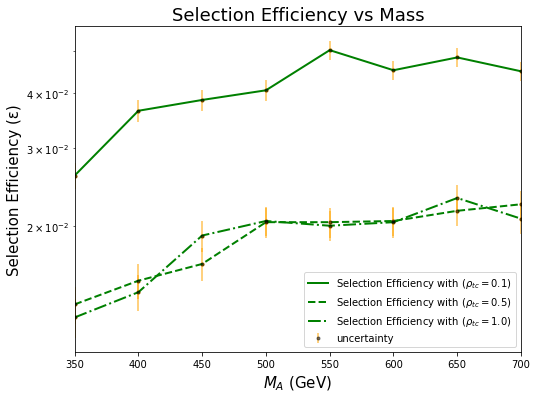

In [32]:
plt.figure(figsize=(8, 6))
ma = np.arange(350, 700+50, 50)
sel_eff, uncer = [], []
m = [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12, m13, m14, m15, m16, m17, m18, m19, m20, m21, m22, m23, m24]
for i in range(len(m)):
    sel_eff.append(m[i][1][1])
    uncer.append(m[i][1][-1])
    
plt.scatter(ma, sel_eff[0:8], marker='.', c = 'orange')
plt.plot(ma, sel_eff[0:8], 'g-', label=r'Selection Efficiency with ($\rho_{tc}=0.1$)', linewidth=2)
plt.errorbar(ma, sel_eff[0:8], yerr=uncer[0:8], fmt='.', color='black', ecolor='orange', elinewidth=2, alpha=0.5, capsize=0, label='uncertainty')

plt.scatter(ma, sel_eff[8:16], marker='.', c = 'orange')
plt.plot(ma, sel_eff[8:16], 'g--', label=r'Selection Efficiency with ($\rho_{tc}=0.5$)', linewidth=2)
plt.errorbar(ma, sel_eff[8:16], yerr=uncer[8:16], fmt='.', color='black', ecolor='orange', elinewidth=2, alpha=0.5, capsize=0)

plt.scatter(ma, sel_eff[16:24], marker='.', c = 'orange')
plt.plot(ma, sel_eff[16:24], 'g-.', label=r'Selection Efficiency with ($\rho_{tc}=1.0$)', linewidth=2)
plt.errorbar(ma, sel_eff[16:24], yerr=uncer[16:24], fmt='.', color='black', ecolor='orange', elinewidth=2, alpha=0.5, capsize=0)

plt.xlim(350, 700)
plt.yscale('log')
plt.title('Selection Efficiency vs Mass', fontsize=18)
plt.xlabel(r'$M_{A}$ (GeV)', fontsize=15)
plt.ylabel('Selection Efficiency (ε)', fontsize=15)
plt.legend(loc='lower right')
plt.show()

In [11]:
ma = np.linspace(350, 700, 8)
A3l_a01 = [m1[-1][2], m2[-1][2], m3[-1][2], m4[-1][2], m5[-1][2], m6[-1][2], m7[-1][2], m8[-1][2]]
A3l_a05 = [m9[-1][2], m10[-1][2], m11[-1][2], m12[-1][2], m13[-1][2], m14[-1][2], m15[-1][2], m16[-1][2]]
A3l_a10 = [m17[-1][2], m18[-1][2], m19[-1][2], m20[-1][2], m21[-1][2], m22[-1][2], m23[-1][2], m24[-1][2]]

plt.figure(figsize=(8, 6))
plt.scatter(ma, A3l_a01, marker='.', c='orange')
plt.scatter(ma, A3l_a05, marker='.', c='orange')
plt.scatter(ma, A3l_a10, marker='.', c='orange')
plt.xlim(350, 700)
plt.ylim(1e-3, 1e-1)
plt.yscale('log')
plt.plot(ma, A3l_a01, 'g-', label=r'$\rho_{tc}=0.1$)', linewidth=2)
plt.plot(ma, A3l_a05, 'g--', label=r'$\rho_{tc}=0.5$)', linewidth=2)
plt.plot(ma, A3l_a10, 'g-.', label=r'$\rho_{tc}=1.0$)', linewidth=2)
plt.errorbar(ma, A3l_a01, yerr=uncer[0:8], fmt='.', color='black', ecolor='orange', elinewidth=2, alpha=0.5, capsize=0, label='uncertainty')
plt.errorbar(ma, A3l_a05, yerr=uncer[8:16], fmt='.', color='black', ecolor='orange', elinewidth=2, alpha=0.5, capsize=0)
plt.errorbar(ma, A3l_a10, yerr=uncer[16:24], fmt='.', color='black', ecolor='orange', elinewidth=2, alpha=0.5, capsize=0)

plt.title('Cross Section vs Mass (3b3l)', fontsize=18)
plt.xlabel(r'$m_{A^o}$ (GeV)', fontsize=15)
plt.ylabel(r'$\sigma_{3b3l}$ (fb)', fontsize=15)
plt.legend(loc='lower left')
plt.show()

NameError: name 'm1' is not defined